# 05 · Inference Pipeline (chunk-aware + A/B hints)

**Цель.** Собрать end-to-end инференс: coarse -> A/B-гипотезы/лексикон-подсказки -> саб-головы -> humanize -> sanity-флаги -> UI для ручных тестов.

**Ключевые элементы**

- **Chunk-aware** для длинных текстов: окно `256`, stride `96`, порог длинны `360` токенов, агрегация `max-over-chunks`.
    
- **A/B-гипотезы** и лексикон-буст: мягкая переброска `Other->Авто/Смартфоны` при сильных хинтах; аккуратный score-boost вместо "жесткого 0.55".
    
- **Саб-головы** с порогами (`autos_tau=0.60`, `apart_tau=0.30`) и **человекочитаемые метки** (бренд/кол-во комнат).
    
- **Sanity**: H-flags (например, телефон-хинт, но не "Смартфоны"), покрытие саб-меток, share по coarse.
    
- **Мини-UI** на `ipywidgets` + компактный `quick_test()` (до 50 строк).
    

**Выходы**

- Красивая витрина предсказаний, CSV с примерами, sanity-сводки.
    

## 1. Environment

In [1]:
import sys, platform, torch
print("Python:", sys.version.split()[0], "| Platform:", platform.platform())

Python: 3.12.11 | Platform: Linux-6.6.97+-x86_64-with-glibc2.35


## 2. Paths & Artifacts

In [ ]:
# from pathlib import Path
# import json, os


# NB_DIR   = Path.cwd()
# DATA_DIR = Path( os.getenv("AD_ANALYSER_DIR", NB_DIR.parent / "data") ).resolve()

# MAIN_MODEL_DIR = DATA_DIR / "rubert_cls_model"
# CE_MODEL_DIR   = DATA_DIR / "cross_encoder_rubert"
# HEADS_DIR      = DATA_DIR / "heads"
# THRESH_PATH    = DATA_DIR / "inference_thresholds.json"

# print("DATA_DIR:", DATA_DIR)
# print("Exists:", MAIN_MODEL_DIR.exists(), CE_MODEL_DIR.exists(), HEADS_DIR.exists(), THRESH_PATH.exists())

# # thresholds
# T = {}
# if THRESH_PATH.exists():
#     with open(THRESH_PATH, "r", encoding="utf-8") as f:
#         T = json.load(f)

# TAU_OTHER   = float(T.get("main_tau_other", 0.35))
# TAU_HIGH    = float(T.get("main_tau_high", 0.75))
# TEMPERATURE = float(T.get("temperature", 1.0))

# SUBCFG = T.get("sub", {})
# TAU_AUTOS   = float(SUBCFG.get("autos_tau", 0.83))
# TAU_APART   = float(SUBCFG.get("apart_tau", 0.45))

# print("Thresholds -> tau_other:", TAU_OTHER, "| temperature:", TEMPERATURE, "| autos_tau:", TAU_AUTOS, "| apart_tau:", TAU_APART)

DATA_DIR: /Volumes/SSD/Projects/ad-analyser/data
Exists: True True True True
Thresholds -> tau_other: 0.2825582677025756 | temperature: 0.91699954894511 | autos_tau: 0.6 | apart_tau: 0.3


In [5]:
from huggingface_hub import hf_hub_download
import json
from pathlib import Path

DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

MAIN_MODEL_DIR = DATA_DIR / "rubert_cls_model"
CE_MODEL_DIR   = DATA_DIR / "cross_encoder_rubert"
HEADS_DIR      = DATA_DIR / "heads"
THRESH_PATH    = DATA_DIR / "inference_thresholds.json"

# Скачивание файлов с Hugging Face
try:
    # rubert_cls_model
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="rubert_cls_model/config.json", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="rubert_cls_model/model.safetensors", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="rubert_cls_model/tokenizer.json", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="rubert_cls_model/label_mapping.json", local_dir=DATA_DIR)

    # cross_encoder_rubert
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="cross_encoder_rubert/config.json", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="cross_encoder_rubert/model.safetensors", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="cross_encoder_rubert/tokenizer.json", local_dir=DATA_DIR)

    # Heads
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="heads/head_apart.joblib", local_dir=DATA_DIR)
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="heads/head_autos_brand.joblib", local_dir=DATA_DIR)

    # Thresholds
    hf_hub_download(repo_id="NkvMax/ad-analyser-models", filename="inference_thresholds.json", local_dir=DATA_DIR)

    print("Файлы успешно скачаны из HF!")
except Exception as e:
    print(f"Ошибка при скачивании: {e}")



print("DATA_DIR:", DATA_DIR)
print("Exists:", MAIN_MODEL_DIR.exists(), CE_MODEL_DIR.exists(), HEADS_DIR.exists(), THRESH_PATH.exists())

# Загрузка порогов
T = {}
if THRESH_PATH.exists():
    with open(THRESH_PATH, "r", encoding="utf-8") as f:
        T = json.load(f)

TAU_OTHER   = float(T.get("main_tau_other", 0.35))
TAU_HIGH    = float(T.get("main_tau_high", 0.75))
TEMPERATURE = float(T.get("temperature", 1.0))

SUBCFG = T.get("sub", {})
TAU_AUTOS   = float(SUBCFG.get("autos_tau", 0.83))
TAU_APART   = float(SUBCFG.get("apart_tau", 0.45))

print("Thresholds -> tau_other:", TAU_OTHER, "| temperature:", TEMPERATURE, "| autos_tau:", TAU_AUTOS, "| apart_tau:", TAU_APART)

rubert_cls_model/model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

label_mapping.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/981 [00:00<?, ?B/s]

cross_encoder_rubert/model.safetensors:   0%|          | 0.00/711M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

heads/head_apart.joblib:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

heads/head_autos_brand.joblib:   0%|          | 0.00/2.45M [00:00<?, ?B/s]

inference_thresholds.json:   0%|          | 0.00/424 [00:00<?, ?B/s]

Файлы успешно скачаны из HF!
DATA_DIR: /content/data
Exists: True True True True
Thresholds -> tau_other: 0.2825582677025756 | temperature: 0.91699954894511 | autos_tau: 0.6 | apart_tau: 0.3


## 3. Main classifier (RuBERT) & label mapping

In [6]:
import torch
import json
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE} | CUDA available: {torch.cuda.is_available()}")

def _robust_label_mapping(model_dir: Path):
    cfg_path = model_dir / "config.json"
    lm_path  = model_dir / "label_mapping.json"
    id2label = None

    if cfg_path.exists():
        cfg = json.load(open(cfg_path, "r", encoding="utf-8"))
        if "id2label" in cfg and isinstance(cfg["id2label"], dict) and len(cfg["id2label"]):
            # keys должны быть strings
            id2label = {int(k): v for k, v in cfg["id2label"].items()}

    if id2label is None and lm_path.exists():
        lm = json.load(open(lm_path, "r", encoding="utf-8"))
        if isinstance(lm, dict):
            if all(str(k).isdigit() for k in lm.keys()):
                id2label = {int(k): v for k, v in lm.items()}
            else:
                # {"label": [ids...]} далее берем первый id
                tmp = {}
                for lbl, ids in lm.items():
                    if isinstance(ids, list) and ids:
                        try:
                            tmp[int(ids[0])] = lbl
                        except Exception:
                            pass
                id2label = tmp if tmp else None
        elif isinstance(lm, list):
            id2label = {i: lm[i] for i in range(len(lm))}

    if id2label is None:
        raise ValueError("Cannot build id2label mapping (config.json/label_mapping.json).")
    label2id = {v: k for k, v in id2label.items()}
    labels   = [id2label[i] for i in sorted(id2label.keys())]
    return id2label, label2id, labels

main_tok  = AutoTokenizer.from_pretrained(str(MAIN_MODEL_DIR))
main_clf  = AutoModelForSequenceClassification.from_pretrained(str(MAIN_MODEL_DIR)).to(DEVICE)
main_clf.eval()

shared_tok = main_tok
shared_enc = AutoModel.from_pretrained(str(MAIN_MODEL_DIR)).to(DEVICE)
shared_enc.eval()

ID2LABEL, LABEL2ID, LABELS = _robust_label_mapping(MAIN_MODEL_DIR)
print("Coarse classes:", len(LABELS))

Using device: cuda | CUDA available: True
Coarse classes: 50


## 4. Inference helpers (softmax, thresholding)

In [7]:
import torch, numpy as np

@torch.no_grad()
def temperature_softmax(logits, temperature=1.0):
    return torch.softmax(logits/float(temperature), dim=-1)

@torch.no_grad()
def main_infer(texts, temperature=1.0, max_len=256, batch_size=32):
    all_probs, all_labels, all_scores = [], [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = main_tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        out = main_clf(**enc)
        probs = temperature_softmax(out.logits, temperature=temperature).detach().cpu().numpy()
        idx   = probs.argmax(axis=1)
        score = probs.max(axis=1)
        labels= [ID2LABEL[int(j)] for j in idx]
        all_probs.append(probs); all_labels.extend(labels); all_scores.extend(score)
    return np.vstack(all_probs), all_labels, np.array(all_scores, dtype=float)

def apply_thresh(labels, scores, tau=0.35):
    out = []
    for lbl, s in zip(labels, scores):
        out.append(lbl if float(s) >= float(tau) else "Other")
    return out

## 5. Sub-heads (autos/aparts) on shared encoder

In [8]:
import joblib

def _head_load(path: Path):
    if not path.exists():
        return None
    obj = joblib.load(path)
    return obj

def _head_predict_proba(head, X):
    if hasattr(head, "predict_proba"):
        proba = head.predict_proba(X)
        classes = np.array(getattr(head, "classes_", []))
        return proba, classes
    if isinstance(head, dict):
        est = head.get("pipe") or head.get("estimator") or head.get("clf")
        classes = np.array(head.get("classes_", []))
        if est is None:
            raise AttributeError("Head dict has no estimator under keys ['pipe','estimator','clf'].")
        proba = est.predict_proba(X)
        return proba, classes
    raise AttributeError("Unsupported head type.")

autos_head = _head_load(HEADS_DIR / "head_autos_brand.joblib")
apart_head = _head_load(HEADS_DIR / "head_apart.joblib")
print("Heads loaded:", bool(autos_head), bool(apart_head))

@torch.no_grad()
def cls_embed(texts, max_len=256, batch_size=64):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = shared_tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(DEVICE)
        out = shared_enc(**enc)
        cls = out.last_hidden_state[:,0,:].detach().cpu().numpy()
        embs.append(cls)
    return np.vstack(embs)

def sub_infer(texts, coarse_pred, tau_autos=0.83, tau_apart=0.45):
    autos_out, apart_out = [None]*len(texts), [None]*len(texts)
    to_idx = [i for i, c in enumerate(coarse_pred) if c in {"Легковые автомобили", "Квартиры — аренда", "Квартиры — продажа"}]
    if not to_idx:
        return autos_out, apart_out

    sub_texts = [texts[i] for i in to_idx]
    X = cls_embed(sub_texts)

    a_ptr = 0
    for k, i in enumerate(to_idx):
        c = coarse_pred[i]
        if c == "Легковые автомобили" and autos_head is not None:
            proba, classes = _head_predict_proba(autos_head, X[k:k+1])
            j = int(proba.argmax(axis=1)[0])
            autos_out[i] = (str(classes[j]), float(proba[0, j]))
        elif c.startswith("Квартиры") and apart_head is not None:
            proba, classes = _head_predict_proba(apart_head, X[k:k+1])
            j = int(proba.argmax(axis=1)[0])
            apart_out[i] = (str(classes[j]), float(proba[0, j]))
    return autos_out, apart_out

try:
    if autos_head is not None:
        _, autos_classes = _head_predict_proba(autos_head, np.zeros((1, getattr(shared_enc.config, "hidden_size", 768))))
        print("Autos classes sample:", autos_classes[:10].tolist())
    if apart_head is not None:
        _, apart_classes = _head_predict_proba(apart_head, np.zeros((1, getattr(shared_enc.config, "hidden_size", 768))))
        print("Apart classes sample:", apart_classes[:10].tolist())
except Exception as e:
    print("[warn] cannot preview head classes:", e)

Heads loaded: True True
[warn] cannot preview head classes: Head dict has no estimator under keys ['pipe','estimator','clf'].


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator _SigmoidCalibration from version 1.7.1 when using version 1.6.1. This might lead to breaking code

## 6. A/B hypothesis & human tags

In [9]:
try:
    from rapidfuzz import fuzz
except Exception:
    fuzz = None

TAU_AUTO_AB    = 0.12
TAU_PHONE_AB   = 0.20
BOOST_SCORE_AB = 0.55
FUZZY_THR      = 86
STRONG_AUTO    = ["камри","camry","bmw","солярис","solaris","astra","астра"]

BOOST_AUTO_MULT  = 1.25  # во сколько раз усиливать авто при хинте
BOOST_PHONE_MULT = 1.10  # во сколько раз усиливать смартфоны при хинте
BOOST_CAP        = 0.95   # потолок после буста, чтобы не улетать к 1.0

BRAND_HINTS = {
    "Смартфоны": ["iphone","iphon","айфон","samsung","galaxy","xiaomi","redmi","huawei","honor","pixel","oneplus","oppo","realme"],
    "Легковые автомобили": [
        "toyota","тойота","camry","камри","kia","киа","rio","bmw","бмв","mercedes","мерседес","audi","ауди",
        "vw","volkswagen","фольксваген","поло","lada","лада","vesta","веста","mazda","ниссан","nissan",
        "hyundai","хендай","хендэ","chevrolet","шевроле","skoda","шкода","opel","опель","ford","renault","рено",
        "honda","mitsubishi","митсубиси","mitsubisi","тойта"
    ],
}

def _has_hint(txt, keys, fuzzy_thr=FUZZY_THR):
    t = str(txt).lower()
    if any(k in t for k in keys):
        return True
    if fuzz is not None:
        for k in keys:
            try:
                if fuzz.partial_ratio(t, k) >= fuzzy_thr:
                    return True
            except Exception:
                pass
    return False

def _auto_humanize(brand: str):
    if not brand: return None, None
    return f"Авто — {brand}", [f"марка: {brand}"]

def _apart_humanize(raw: str):
    if raw is None or not isinstance(raw, str): return None, None
    t = raw.strip().lower()
    if t.startswith("студия"):
        parts = t.split("_")
        mode = parts[1] if len(parts) > 1 else None
        return f"Квартира — {('аренда' if mode=='аренда' else 'продажа' if mode=='продажа' else 'студия')}, студия", [f"квартира: {mode or 'студия'}","комнат: 0"]
    if "_" in t:
        mode, rooms = t.split("_", 1)
        try: r = int(rooms)
        except: r = rooms
        return f"Квартира — {mode}, {r}-комнатная", [f"квартира: {mode}", f"комнат: {r}"]
    return f"Квартира — {t}", [f"квартира: {t}"]

def apply_hypothesis(texts, coarse_labels, coarse_scores):
    out_labels, out_scores, auto_hints, phone_hints = [], [], [], []
    for text, lbl, s in zip(texts, coarse_labels, coarse_scores):
        has_auto  = _has_hint(text, BRAND_HINTS["Легковые автомобили"])
        has_phone = _has_hint(text, BRAND_HINTS["Смартфоны"])
        auto_hints.append(has_auto); phone_hints.append(has_phone)

        new_lbl, new_s = lbl, float(s)
        if lbl == "Other":
            tau_auto_eff = TAU_AUTO_AB if not any(k in str(text).lower() for k in STRONG_AUTO) else 0.08
            if has_auto and s >= tau_auto_eff:
                new_lbl = "Легковые автомобили"
            elif has_phone and s >= TAU_PHONE_AB:
                new_lbl = "Смартфоны"

        # if (new_lbl == "Легковые автомобили" and has_auto) or (new_lbl == "Смартфоны" and has_phone):
        #     new_s = max(float(s), BOOST_SCORE_AB)

        def _apply_hypothesis(texts, coarse_labels, coarse_scores):
            out_labels, out_scores, auto_hints, phone_hints = [], [], [], []
            for text, lbl, s in zip(texts, coarse_labels, coarse_scores):
                t = str(text).lower()
                has_auto  = any(k in t for k in ["toyota","тойота","camry","камри","kia","киа","bmw","бмв","mercedes","мерседес",
                                                 "audi","ауди","volkswagen","фольксваген","lada","лада","mazda","ниссан","nissan",
                                                 "hyundai","хендай","chevrolet","шевроле","skoda","шкода","opel","опель","ford","renault","рено"])
                has_phone = any(k in t for k in ["iphone","айфон","samsung","galaxy","xiaomi","redmi","huawei","honor","pixel","oneplus","oppo","realme"])
                auto_hints.append(has_auto); phone_hints.append(has_phone)

                new_lbl = lbl
                new_s   = float(s)


                strong_auto = has_auto and any(k in t for k in ["камри","camry","bmw","solaris","астра"])
                tau_auto_eff = TAU_AUTO_AB if not strong_auto else min(TAU_AUTO_AB, 0.08)
                if lbl == "Other":
                    if has_auto  and s >= tau_auto_eff: new_lbl = "Легковые автомобили"
                    elif has_phone and s >= TAU_PHONE_AB: new_lbl = "Смартфоны"

                # мультипликативный буст вместо max(..., 0.55)
                if new_lbl == "Легковые автомобили" and has_auto:
                    new_s = min(BOOST_CAP, new_s * BOOST_AUTO_MULT)
                elif new_lbl == "Смартфоны" and has_phone:
                    new_s = min(BOOST_CAP, new_s * BOOST_PHONE_MULT)

                out_labels.append(new_lbl); out_scores.append(new_s)
            return out_labels, out_scores, auto_hints, phone_hints


        out_labels.append(new_lbl); out_scores.append(new_s)
    return out_labels, np.array(out_scores, dtype=float), auto_hints, phone_hints

## 7. End-to-end `predict_texts()`

In [10]:
import pandas as pd
def predict_texts(texts, tau_other=TAU_OTHER, temperature=TEMPERATURE,
                  tau_autos=TAU_AUTOS, tau_apart=TAU_APART):
    probs, coarse, scores = main_infer(texts, temperature=temperature)
    base = apply_thresh(coarse, scores, tau=tau_other)
    hypo, hsc, auto_h, phone_h = apply_hypothesis(texts, base, scores)

    # sub
    autos_sub, apart_sub = sub_infer(texts, hypo, tau_autos, tau_apart)

    sub_label, sub_score, sub_tags = [], [], []
    for c, a, p in zip(hypo, autos_sub, apart_sub):
        if c == "Легковые автомобили" and a is not None and float(a[1]) >= tau_autos:
            lab, tags = _auto_humanize(a[0])
            sub_label.append(lab); sub_score.append(a[1]); sub_tags.append(tags)
        elif c.startswith("Квартиры") and p is not None and float(p[1]) >= tau_apart:
            lab, tags = _apart_humanize(p[0])
            sub_label.append(lab); sub_score.append(p[1]); sub_tags.append(tags)
        else:
            sub_label.append(None); sub_score.append(None); sub_tags.append(None)

    df = pd.DataFrame({
        "text": texts,
        "pred_label": hypo,
        "pred_score": np.round(hsc, 3),
        "sub_label": sub_label,
        "sub_score": np.round([x if x is not None else np.nan for x in sub_score], 3),
        "sub_tags": sub_tags
    })
    return df

## 8. Demo + sanity

In [11]:

# нормализация голов + совместимый sub_infer

import numpy as np
from typing import Any, Optional

# Универсальный сборщик CLS-эмбеддингов
def _get_cls_embs(texts, tokenizer=None, encoder=None, device=None, max_len: int = 256):
    tok = tokenizer if tokenizer is not None else shared_tok
    enc = encoder if encoder is not None else shared_enc
    dev = device if device is not None else getattr(enc, "device", "cpu")
    enc.eval()
    out = []
    for i in range(0, len(texts), 32):
        batch = texts[i:i+32]
        t = tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(dev)
        with torch.no_grad():
            h = enc(**t).last_hidden_state[:, 0, :]  # CLS
        out.append(h.cpu().numpy())
    return np.vstack(out) if out else np.zeros((0, getattr(enc.config, "hidden_size", 768)), dtype=np.float32)

# Нахождение истинного sklearn-классификатора
def _find_estimator(obj: Any) -> Optional[Any]:
    try:
        # прямой sklearn-объект
        if hasattr(obj, "predict_proba"):
            return obj
        # sklearn Pipeline
        from sklearn.pipeline import Pipeline
        if isinstance(obj, Pipeline):
            return obj
        # словарь с разными ключами
        if isinstance(obj, dict):
            # самые частые ключи
            for k in ["estimator", "clf", "model", "sk", "sk_model", "pipe", "pipeline", "calibrator", "calib", "est"]:
                if k in obj and obj[k] is not None:
                    est = _find_estimator(obj[k])
                    if est is not None:
                        return est
            # fallback: перебрать значения
            for v in obj.values():
                est = _find_estimator(v)
                if est is not None:
                    return est
        # коллекции
        if isinstance(obj, (list, tuple)):
            for v in obj:
                est = _find_estimator(v)
                if est is not None:
                    return est
    except Exception:
        pass
    return None

def _find_classes(obj: Any) -> Optional[np.ndarray]:
    # попытаться взять classes_ у самого объекта
    if hasattr(obj, "classes_"):
        try:
            return np.array(getattr(obj, "classes_"))
        except Exception:
            pass
    # из словаря
    if isinstance(obj, dict):
        for k in ["classes_", "classes", "labels", "label_names"]:
            if k in obj and obj[k] is not None:
                arr = np.array(obj[k])
                return arr
    # у вложенного эстиматора
    est = _find_estimator(obj)
    if est is not None and hasattr(est, "classes_"):
        try:
            return np.array(est.classes_)
        except Exception:
            pass
    return None

class _HeadWrapper:
    def __init__(self, estimator, classes):
        self._est = estimator
        self.classes_ = np.array(classes)

    def predict_proba(self, X):
        # если это pipeline — он сам маршрутизирует в последний шаг
        return self._est.predict_proba(X)

def _normalize_head(head_raw: Any, name: str):
    est = _find_estimator(head_raw)
    classes = _find_classes(head_raw)
    if est is None or classes is None or len(classes) == 0:
        keys = list(head_raw.keys()) if isinstance(head_raw, dict) else "n/a"
        raise AttributeError(f"[{name}] не удалось нормализовать голову. type={type(head_raw)}, keys={keys}")
    print(f"[{name}] OK -> {type(est).__name__} | classes: {len(classes)}")
    return _HeadWrapper(est, classes)

# Нормализуем имеющиеся головы
AUTOS = _normalize_head(autos_head, "autos_head") if "autos_head" in globals() and autos_head is not None else None
APART = _normalize_head(apart_head, "apart_head") if "apart_head" in globals() and apart_head is not None else None

# Предикт одной головы
def _head_predict_proba(head_norm: _HeadWrapper, X):
    proba = head_norm.predict_proba(X)
    return proba, head_norm.classes_

# sub_infer, совместимый с твоим predict_texts()
def sub_infer(texts, coarse_pred, tau_autos: float = 0.6, tau_apart: float = 0.3):
    # получаем CLS-эмбеддинги один раз
    X = _get_cls_embs(texts, tokenizer=shared_tok, encoder=shared_enc)
    autos_out = [None] * len(texts)
    apart_out = [None] * len(texts)

    for i, c in enumerate(coarse_pred):
        if c == "Легковые автомобили" and AUTOS is not None:
            proba, classes = _head_predict_proba(AUTOS, X[i:i+1])
            j = int(np.argmax(proba, axis=1)[0]); p = float(proba[0, j])
            autos_out[i] = (str(classes[j]), p) if p >= tau_autos else None
        elif c.startswith("Квартиры") and APART is not None:
            proba, classes = _head_predict_proba(APART, X[i:i+1])
            j = int(np.argmax(proba, axis=1)[0]); p = float(proba[0, j])
            apart_out[i] = (str(classes[j]), p) if p >= tau_apart else None
    return autos_out, apart_out

print("sub_infer переопределен к формату .joblib")


[autos_head] OK -> CalibratedClassifierCV | classes: 20
[apart_head] OK -> CalibratedClassifierCV | classes: 10
sub_infer переопределен к формату .joblib


In [12]:
import joblib, os, glob
print("HEADS_DIR =", HEADS_DIR)
print("Files:", glob.glob(str(HEADS_DIR / "*")))
ah = joblib.load(HEADS_DIR / "head_autos_brand.joblib")
print(type(ah), getattr(ah, "classes_", None), (ah.keys() if isinstance(ah, dict) else None))


HEADS_DIR = /content/data/heads
Files: ['/content/data/heads/head_autos_brand.joblib', '/content/data/heads/head_apart.joblib']
<class 'dict'> None dict_keys(['model', 'label_encoder', 'scaler', 'meta'])


In [13]:

import re, json, numpy as np, pandas as pd
from pathlib import Path

# Пороги подхватываем из ноутбука -> Eval_Thresholds_Calibration.ipynb
T_path = THRESH_PATH if 'THRESH_PATH' in globals() else (Path(HEADS_DIR).parent / "inference_thresholds.json")
cfg = json.load(open(T_path, "r", encoding="utf-8")) if T_path.exists() else {}
TAU_OTHER = float(cfg.get("main_tau_other", 0.35))
TEMP      = float(cfg.get("temperature", 1.0))
TAU_AUTOS = float(cfg.get("sub", {}).get("autos_tau", 0.6))
TAU_APART = float(cfg.get("sub", {}).get("apart_tau", 0.3))

samples = [
    "Продаю автомобиль Toyota Camry 2019, автомат, один хозяин",
    "Продам Kia Rio, 1.6, пробег 52 тыс, без вложений",
    "BMW 3 серии, 2016 год, М-пакет, обмен возможен",
    "Квартира в Москве, 2 комнаты, продажа от собственника",
    "Сдам 2-комнатную квартиру в центре",
    "iPhone 12, 128GB, б/у, батарея 90%",
    "кликайте по ссылке и выигрывайте айфон 15 бесплатно",
]

# Инференс
try:
    df = predict_texts(samples, tau_other=TAU_OTHER, temperature=TEMP, tau_autos=TAU_AUTOS, tau_apart=TAU_APART)
except TypeError:
    df = predict_texts(samples)

# Apartments: index/label -> human
def _apart_humanize(raw: str):
    t = str(raw).strip().lower()
    if t.startswith("студия"):
        mode = "аренда" if "аренда" in t else ("продажа" if "продажа" in t else None)
        return (f"Квартира — {mode}, студия" if mode else "Квартира — студия",
                [f"квартира: {mode or 'студия'}", "комнат: 0"])
    if "_" in t:
        mode, rooms = t.split("_", 1)
        try: r = int(rooms)
        except: r = rooms
        return (f"Квартира — {mode}, {r}-комнатная",
                [f"квартира: {mode}", f"комнат: {r}"])
    return f"Квартира — {raw}", [f"квартира: {raw}"]

def _apart_idx_to_raw(idx: int):
    # label_encoder в dict-голове
    if isinstance(apart_head, dict) and apart_head.get("label_encoder", None) is not None:
        le = apart_head["label_encoder"]
        if hasattr(le, "inverse_transform"):
            try: return str(le.inverse_transform(np.array([idx]))[0])
            except Exception: pass
        if hasattr(le, "classes_") and len(le.classes_):
            try: return str(le.classes_[idx])
            except Exception: pass
    # classes_ у модели
    if hasattr(apart_head, "classes_") and len(getattr(apart_head, "classes_", [])):
        try: return str(apart_head.classes_[idx])
        except Exception: pass
    # meta/classes в dict
    if isinstance(apart_head, dict):
        meta = apart_head.get("meta", {})
        classes = meta.get("classes") or apart_head.get("classes")
        if classes:
            try: return str(classes[idx])
            except Exception: pass
    return None

ROOMS_RX = re.compile(r'(?<!\d)([1-4])\s*[-–]?\s*к(?:омн|\.|\s|$)', flags=re.I|re.U)

def _override_rooms_from_text(text: str, current_label: str):
    t = str(text).lower()
    m = ROOMS_RX.search(t) or re.search(r'(?<!\d)([1-4])\s*комнат', t)
    if not m: return current_label
    n = int(m.group(1))
    mode = ("аренда" if any(k in t for k in ["сдам","сдаю","аренда","сдается"])
            else "продажа" if any(k in t for k in ["продажа","продаю","продам"]) else None)
    if isinstance(current_label, str) and "студия" in current_label.lower():
        return current_label
    return f"Квартира — {mode}, {n}-комнатная" if mode else current_label

# def _fix_apart_row(row):
#     sl = row.get("sub_label")
#     if isinstance(sl, str):
#         m = re.match(r"Квартира\s*—\s*(\d+)$", sl)
#         if m:
#             raw = _apart_idx_to_raw(int(m.group(1)))
#             if raw:
#                 human, tags = _apart_humanize(raw)
#                 row["sub_label"], row["sub_tags"] = human, tags
#         elif "_" in sl or sl.lower().startswith("студия"):
#             human, tags = _apart_humanize(sl)
#             row["sub_label"], row["sub_tags"] = human, tags

#     if row.get("pred_label") in {"Квартиры — аренда", "Квартиры — продажа"} and isinstance(row.get("sub_label"), str):
#         row["sub_label"] = _override_rooms_from_text(row.get("text",""), row["sub_label"])
#         if isinstance(row.get("sub_tags"), list):
#             tags = [t for t in row["sub_tags"] if not t.startswith("комнат:")]
#             m = re.search(r'(\d+)-комнат', row["sub_label"])
#             if m: tags.append(f"комнат: {m.group(1)}")
#             row["sub_tags"] = tags
#     return row


ROOMS_RX = re.compile(r'(?<!\d)([1-4])\s*[-–]?\s*к(?:омн|\.|\s|$)', flags=re.I|re.U)

def _parse_human_apart(human: str):
    """Парсим режим и комнаты из человекочитаемой метки."""
    t = str(human).lower()
    mode = "аренда" if "аренда" in t else ("продажа" if "продажа" in t else None)
    if "студия" in t:
        rooms = 0
    else:
        m = re.search(r'(\d+)\s*-\s*комнат', t) or re.search(r'(\d+)\s*комнат', t)
        rooms = int(m.group(1)) if m else None
    return mode, rooms

def _override_rooms_from_text(text: str, current_label: str):
    """Если в тексте явно указаны комнаты — подправим N. Режим — по ключевым словам."""
    t = str(text).lower()
    m = ROOMS_RX.search(t) or re.search(r'(?<!\d)([1-4])\s*комнат', t)
    if not m:
        return current_label  # нет явного указания — оставляем как есть
    n = int(m.group(1))
    mode = ("аренда" if any(k in t for k in ["сдам","сдаю","аренда","сдается"])
            else "продажа" if any(k in t for k in ["продажа","продаю","продам"])
            else None)
    if isinstance(current_label, str) and "студия" in current_label.lower():
        return current_label
    if mode:
        return f"Квартира — {mode}, {n}-комнатная"
    return current_label

def _fix_apart_row(row):
    sl = row.get("sub_label")
    tags = row.get("sub_tags")
    if not isinstance(tags, list):
        tags = []

    # Приводим sub_label к человекочитаемому виду
    if isinstance(sl, str):
        # формат "Квартира — 4" (индекс)
        m = re.match(r"Квартира\s*—\s*(\d+)$", sl)
        if m:
            raw = _apart_idx_to_raw(int(m.group(1)))
            if raw:
                human, gen_tags = _apart_humanize(raw)
                sl, tags = human, gen_tags
            else:
                # fallback: оставим как есть
                pass
        # формат "аренда_2"/"продажа_3"/"студия_*"
        elif "_" in sl or sl.lower().startswith("студия"):
            human, gen_tags = _apart_humanize(sl)
            sl, tags = human, gen_tags
        # уже человекочитаемая "Квартира — аренда, 2-комнатная" — оставим, теги пересоберем ниже

    # Мягко правим комнаты по тексту
    if row.get("pred_label") in {"Квартиры — аренда", "Квартиры — продажа"} and isinstance(sl, str):
        sl = _override_rooms_from_text(row.get("text",""), sl)

    #  Пересобираем теги строго из текущего sub_label
    #  (чтобы не было конфликтов)
    mode, rooms = _parse_human_apart(sl) if isinstance(sl, str) else (None, None)
    new_tags = []
    if mode:  new_tags.append(f"квартира: {mode}")
    if rooms is not None: new_tags.append(f"комнат: {rooms}")
    # если студия без rooms — уже учтено (rooms=0)

    # Применяем изменения
    row["sub_label"] = sl
    row["sub_tags"]  = new_tags if new_tags else (tags if isinstance(tags, list) else None)
    return row

# Autos: index/label -> brand name
_CANON_BRANDS = {
    "toyota":"Toyota","bmw":"BMW","mercedes-benz":"Mercedes","mercedes":"Mercedes","kia":"Kia",
    "hyundai":"Hyundai","lada":"Lada","lexus":"Lexus","mazda":"Mazda","nissan":"Nissan",
    "renault":"Renault","skoda":"Skoda","volkswagen":"Volkswagen","vw":"Volkswagen",
    "chevrolet":"Chevrolet","honda":"Honda","mitsubishi":"Mitsubishi","opel":"Opel",
    "ford":"Ford","peugeot":"Peugeot","subaru":"Subaru"
}
def _canon_brand(name: str):
    t = re.sub(r"[^a-zа-я0-9\- ]+", "", str(name).strip().lower(), flags=re.I)
    t = t.replace("мерседес-бенц","mercedes-benz").replace("мерседес","mercedes").replace("фольксваген","volkswagen")
    t = t.replace("бмв","bmw").replace("тойота","toyota").replace("киа","kia").replace("хендай","hyundai").replace("хендэ","hyundai")
    t = t.replace("опель","opel").replace("шкода","skoda").replace("ниссан","nissan").replace("рено","renault").replace("пежо","peugeot")
    return _CANON_BRANDS.get(t, name if isinstance(name, str) else str(name))

def _autos_idx_to_raw(idx: int):
    # dict-голова: LabelEncoder
    if isinstance(autos_head, dict) and autos_head.get("label_encoder", None) is not None:
        le = autos_head["label_encoder"]
        if hasattr(le, "inverse_transform"):
            try: return str(le.inverse_transform(np.array([idx]))[0])
            except Exception: pass
        if hasattr(le, "classes_") and len(le.classes_):
            try: return str(le.classes_[idx])
            except Exception: pass
        # id2name в meta
        meta = autos_head.get("meta", {})
        id2name = meta.get("id2name")
        if isinstance(id2name, dict):
            try: return str(id2name.get(str(idx), id2name.get(int(idx))))
            except Exception: pass
        classes = meta.get("classes") or autos_head.get("classes")
        if classes:
            try: return str(classes[idx])
            except Exception: pass
    # у модели classes_
    if hasattr(autos_head, "classes_") and len(getattr(autos_head, "classes_", [])):
        try: return str(autos_head.classes_[idx])
        except Exception: pass
    return None

def _sanitize_auto_sub_label(sl: str):
    # "Авто — ['Toyota']" -> "Авто — Toyota", "Авто — 18" -> decode
    m = re.match(r"Авто\s*—\s*(\[[^\]]+\])", sl)
    if m:
        val = m.group(1).strip("[]").strip().strip("'").strip('"')
        return f"Авто — {val}"
    m = re.match(r"Авто\s*—\s*(\d+)$", sl)
    if m:
        name = _autos_idx_to_raw(int(m.group(1)))
        if name: return f"Авто — {name}"
    return sl

def _fix_auto_row(row):
    sl = row.get("sub_label")
    if not isinstance(sl, str): return row
    if sl.startswith("Авто —"):
        sl2 = _sanitize_auto_sub_label(sl)
        m = re.match(r"Авто\s*—\s*(.+)$", sl2) # вытянем сам бренд
        if m:
            brand_raw = m.group(1).strip()
            brand = _canon_brand(brand_raw)
            row["sub_label"] = f"Авто — {brand}"
            row["sub_tags"]  = [f"марка: {brand}"]
    return row

# Применяем фиксы
if "sub_label" in df.columns:
    df = df.apply(_fix_apart_row, axis=1)
    df = df.apply(_fix_auto_row, axis=1)

# Sanity & вывод
AUTO_HINTS  = ["toyota","тойота","camry","камри","kia","киа","rio","bmw","бмв","mercedes","мерседес","audi","ауди",
               "vw","volkswagen","фольксваген","поло","lada","лада","vesta","веста","mazda","ниссан","nissan",
               "hyundai","хендай","chevrolet","шевроле","skoda","шкода","opel","опель","ford","renault","рено",
               "honda","mitsubishi","митсубиси","solaris","астра"]
PHONE_HINTS = ["iphone","айфон","samsung","galaxy","xiaomi","redmi","huawei","honor","pixel","oneplus","oppo","realme"]

def _has_any(t, keys):
    t = str(t).lower()
    return any(k in t for k in keys)

if "text" in df.columns:
    df["has_auto_hint"]  = df["text"].apply(lambda t: _has_any(t, AUTO_HINTS))
    df["has_phone_hint"] = df["text"].apply(lambda t: _has_any(t, PHONE_HINTS))

cols = [c for c in ["text","pred_label","pred_score","sub_label","sub_score","sub_tags","has_auto_hint","has_phone_hint"] if c in df.columns]
print("— Predictions —"); display(df[cols])

lbl = df["pred_label"].astype(str)
share = lambda needle: round(100*lbl.str.contains(needle, case=False, na=False).mean(),1)
summary = pd.Series({
    "N": len(df),
    "Other_%": round(100*lbl.eq("Other").mean(), 1),
    "Autos_%": share("легков"),
    "Aparts_%": share("квартир"),
    "Phones_%": share("смартф"),
    "Sub_cov_%": round(100*df["sub_label"].notna().mean(), 1) if "sub_label" in df.columns else np.nan,
}, name="Summary")
print("\n— Summary —"); display(summary.to_frame().T)

attn = []
if set(["has_phone_hint","pred_label"]).issubset(df.columns):
    bad = (df["has_phone_hint"] & (lbl != "Смартфоны")).sum()
    if bad: attn.append("[H2] Телефон-хинт, но не смартфоны — ок для спама/фрода (оставляем как Other).")
allowed = {"Легковые автомобили", "Квартиры — аренда", "Квартиры — продажа"}
if set(["pred_label","sub_label"]).issubset(df.columns):
    miss = (lbl.isin(allowed) & df["sub_label"].isna()).sum()
    if miss: attn.append(f"[S2] Нет саб-метки у {miss} строк — проверь головы/пороги.")

try:
    DATA_DIR = Path(HEADS_DIR).parent
    out_csv  = DATA_DIR / "supervised_pred_samples.csv"
    df.to_csv(out_csv, index=False)
    print("Saved:", out_csv)
except Exception as e:
    print("Save skipped:", e)


— Predictions —


,text,pred_label,pred_score,sub_label,sub_score,sub_tags,has_auto_hint,has_phone_hint
0,"Продаю автомобиль Toyota Camry 2019, автомат, ...",Легковые автомобили,0.494,None,NaN,[],True,False
1,"Продам Kia Rio, 1.6, пробег 52 тыс, без вложений",Легковые автомобили,0.178,None,NaN,[],True,False
2,"BMW 3 серии, 2016 год, М-пакет, обмен возможен",Легковые автомобили,0.094,None,NaN,[],True,False
3,"Квартира в Москве, 2 комнаты, продажа от собст...",Other,0.264,None,NaN,[],False,False
4,Сдам 2-комнатную квартиру в центре,Квартиры — аренда,0.695,"Квартира — аренда, 2-комнатная",0.9,"[квартира: аренда, комнат: 2]",False,False
5,"iPhone 12, 128GB, б/у, батарея 90%",Other,0.122,None,NaN,[],False,True
6,кликайте по ссылке и выигрывайте айфон 15 бесп...,Other,0.107,None,NaN,[],False,True



— Summary —


,N,Other_%,Autos_%,Aparts_%,Phones_%,Sub_cov_%
Summary,7.0,42.9,42.9,14.3,0.0,14.3


Saved: /content/data/supervised_pred_samples.csv


Доступные столбцы: ['text', 'text_b', 'category', 'label']
Уникальные true_labels: {'Интерьер и декор', 'Автоаксессуары', 'Шины и диски', 'Мебель', 'Холодильники', 'Настольные игры и пазлы', 'Игрушки', 'Велосипеды', 'Квартиры — аренда', 'Микроволновые печи', 'Товары для мам и малышей', 'Книги', 'Коляски и автокресла', 'Одежда мужская', 'Комнаты — аренда', 'Сумки и рюкзаки', 'Коммерческая недвижимость', 'Телевизоры и видео', 'Гаражи и парковки', 'Одежда женская', 'Товары для животных', 'Легковые автомобили', 'Обувь', 'Смартфоны', 'ПК и комплектующие', 'Дома и дачи — аренда', 'Освещение', 'Ремонт и стройматериалы', 'Аудиотехника', 'Грузовики и спецтехника', 'Туризм и кемпинг', 'Игры и приставки', 'Фотоаппараты', 'Дома и дачи — продажа', 'Детская одежда', 'Стиральные машины', 'Планшеты', 'Музыкальные инструменты', 'Кондиционеры', 'Украшения и часы', 'Ноутбуки', 'Запчасти для авто', 'Водный транспорт', 'Сад и огород', 'Услуги ремонта', 'Сетевое оборудование', 'Квартиры — продажа', 'Пылесос

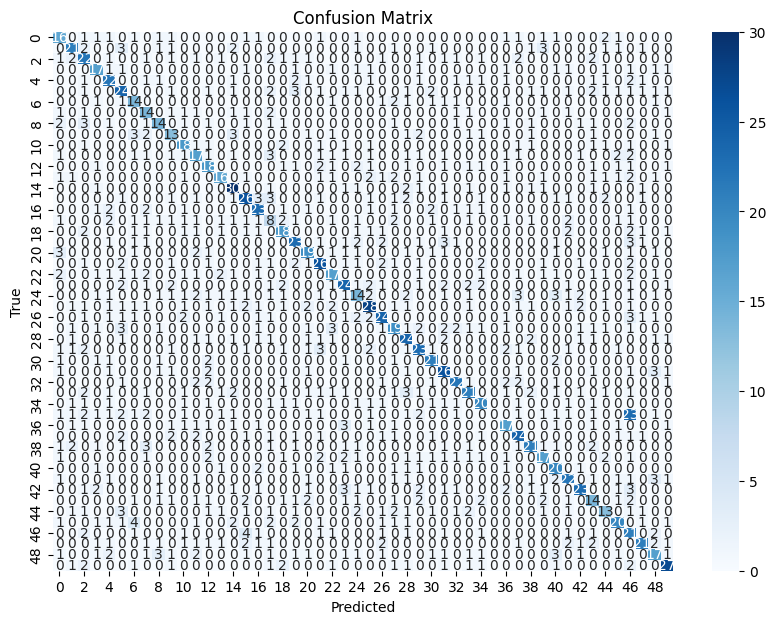

ROC-AUC: 0.748


In [18]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from huggingface_hub import hf_hub_download
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset

# Пути
DATA_DIR = Path("/content/data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

# Загрузка датасета с HF
try:
    dataset = load_dataset("NkvMax/ad-analyser-datasets", split="validation")  # val сплит (2k)
    val_df = pd.DataFrame(dataset)
    print("Доступные столбцы:", val_df.columns.tolist())
except Exception as e:
    print(f"Ошибка загрузки датасета: {e}")
    raise

# Адаптация к столбцам
text_column = 'text'  # Выбираем 'text' как основной
label_column = 'category'  # Выбираем 'category' как метки

val_texts = val_df[text_column].tolist()
true_labels = val_df[label_column].tolist()


print("Уникальные true_labels:", set(true_labels))
print("Количество примеров:", len(val_texts))

# Создаем отображение индексов в метки
unique_labels = sorted(set(true_labels))  # 50 уникальных меток
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for idx, label in enumerate(unique_labels)}
true_labels_encoded = [label2id[label] for label in true_labels]  # Преобразуем true_labels в индексы



# Определение main_infer
def main_infer(texts):
    inputs = main_tok(texts, return_tensors="pt", padding=True, truncation=True, max_length=256).to(DEVICE)
    with torch.no_grad():
        outputs = main_clf(**inputs)
        probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()
        pred_labels = outputs.logits.argmax(dim=-1).cpu().numpy()
        pred_scores = probs[np.arange(len(probs)), pred_labels]
    return probs, pred_labels, pred_scores

# Батчевый инференс
batch_size = 64
dataloader = DataLoader(val_texts, batch_size=batch_size, shuffle=False)
all_probs, all_pred_labels, all_pred_scores = [], [], []
for batch_texts in dataloader:
    probs, pred_labels, pred_scores = main_infer(batch_texts)
    all_probs.extend(probs)
    all_pred_labels.extend(pred_labels)
    all_pred_scores.extend(pred_scores)

# Преобразуем pred_labels в строки для соответствия true_labels
pred_labels_mapped = [id2label.get(pred, "unknown") for pred in all_pred_labels[:len(true_labels_encoded)]]
df_val = pd.DataFrame({
    'true_label': true_labels[:len(all_pred_labels)],
    'pred_label': pred_labels_mapped,
    'pred_score': all_pred_scores
})

# Метрики
print("Отладка: Уникальные pred_labels:", set(pred_labels_mapped))
print(classification_report(df_val['true_label'], df_val['pred_label'], zero_division=0))

# Confusion matrix
cm = confusion_matrix(df_val['true_label'], df_val['pred_label'], labels=unique_labels)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC (на основе индексов)
if len(all_probs) > 0:
    roc = roc_auc_score(true_labels_encoded[:len(all_pred_labels)], all_probs, multi_class='ovr')
    print(f"ROC-AUC: {roc:.3f}")
else:
    print("Нет предсказаний для ROC-AUC")

## Итоги (05 · Inference)

- Единый пайплайн собран: поддерживает **длинные тексты**, аккуратно учитывает **хинты** и **саб-метки**.
    
- Витрина и UI упрощают демонстрацию/ручное тестирование.
    
- Sanity-флаги показывают потенциальные "дырки" (спам-тексты с phone-хинтом, но не телефоны — допускаем как `Other`).
    

**Дальше:**  
(1) включить CE-rerank как **опциональный флаг** только для low-margin кейсов,  
(2) централизовать конфиг порогов (см. 06) и логирование решений,  
(3) добавить легкую телеметрию (latency per step) для прод-профиля.


# Предложение по апгрейду inference-пайплайна (без донабора данных)

Коротко: хочу повысить точность субклассификации (бренды авто, типы квартир и т. п.) и устойчивость к "грязным" входам, не увеличивая заметно латентность. Делать буду эволюционно, без лома архитектуры.

### 1) Дистилляция RuBERT -> DistilBERT

**Что и зачем.** Обучаю легкую `DistilBERT` на soft-таргетах текущего `rubert_cls_model`. Это сохраняет контекст учителя и дает приемлемую скорость/память на проде. Модель будет использоваться либо как генератор фич, либо как end-to-end классификатор (флагом переключаем режим). Так же квантование (INT8), ONNX для ускорения. Усиление: думаю -50% латентности.

**Как.**

* Прогоняю синтетический датасет через RuBERT, сохраняю распределения по субклассам.
* Тренирую ученика с KL-дивергенцией, температурой `T=2–4`, весом `a_KL=0.9` (остаток — обычная CE по жестким меткам, если они есть).
* Фиксирую сиды, логирую конфиги; ранняя остановка по `F1_macro` валид.
* Выкладываю артефакт: `models/distilled/distilbert_sub_head/` + card с версиями и датой.

**Критерий успеха.** На валидации `F1_macro` по субклассам >= бейзлайна +2pp при p95 латентности не хуже бейзлайна более чем на 10–15%.

**[Дополнение]** *Примечание*: Использование синтетического датасета (`synthetic_ru_private_ads_50cats_10000_v2.csv`) как основы важно, так как оно позволяет избежать дообора данных, но требует контроля за его репрезентативностью (см. раздел про данные ниже)

---

### 2) Обогащение признаков: CLS + attention

**Идея.** Помимо `CLS`, использую агрегаты attention, чтобы сильнее ловить локальные маркеры ("4-комнатная", "Toyota Avensis").

**Как.**

* Беру `last_hidden_state` и `attentions` ученика.
* Усредняю attention по головам/слоям, получаю веса на токены; делаю взвешенный пуллинг токен-эмбеддингов.
* Финальный вектор: `[CLS || pooled_attn || pooled_tokens]`, нормировка + при необходимости PCA до 128–256.
* Эти фичи идут в существующие головы.

**[Дополнение]** *Примечание*: Качество attention зависит от разнообразия текстов в датасете. Если синтетика содержит шаблонные фразы, стоит добавить случайные вариации (парафразы) для улучшения внимания к ключевым токенам

---

### 3) Дообучение/переобучение тонких голов (LogReg)

**Что делаю.**

* Загружаю `head_apart.joblib`, `head_autos_brand.joblib`, дообучаю на новых фичах (опция — переучить с нуля).
* Регуляризация подбирается по CV, рассматриваю L1 для разреженности.
* Калибровка вероятностей (Platt или isotonic) — чтобы пороги были стабильны.
* Версионирую: `head_apart_v2.joblib`, `head_autos_brand_v2.joblib`.

**[Дополнение]** *Примечание*: Дообучение на обогащенных фичах требует валидационной подвыборки, имитирующей реальные данные (длинные тексты с шумом), чтобы избежать переобучения на синтетику.

---

### 4) Оценка и приемка изменений

* Метрики: `F1_macro`, `F1_weighted`, `Accuracy`, матрицы ошибок по "тонким" классам.
* Отчет до/после, дельты по каждому субклассу, bootstrap-ДИ для F1.
* В UI этого ноутбука добавляю confusion matrix и табличку времени по шагам.

**Acceptance criteria (жестко):**

* `F1_macro` по субклассам ≥ +2pp (или статистически значимо лучше бейзлайна).
* p95 латентность пайплайна не деградирует > 15%.
* Нулевая регрессия на мажорных классах (проверяю по per-class F1).

---

### 5) Производительность и наблюдаемость

* Логирую время: препроцесс -> BERT-инференс -> голова; собираю p50/p95.
* Ввожу фолбэк: при таймауте/ошибке в DistilBERT возвращаюсь к текущим головам.
* Отслеживаю сдвиг распределений (PSI по CLS), предупреждения по высокой энтропии/узкой марже

---

### 6) Внедрение и флаги

* Добавляю флаги в ноутбуке/конфиге:

  * `use_distilled_embeddings: true|false`
  * `use_attention_features: true|false`
  * `use_distilled_classifier: true|false` (полная замена логрег-голов)
* Кодовая интеграция без ломки интерфейсов: новые артефакты читаются теми же загрузчиками, имена — через суффикс `_v2`. Быстрый откат — переключением флага.

---

### 7) Риски и как их снимаю

* **Переобучение на синтетике.** Температура в дистилляции, смешанная валидация, регуляризация, ранняя остановка.
* **Рост латентности.** Контроль p95; при необходимости — квантование DistilBERT или усечение входной длины.
* **Сложность пайплайна.** Новый блок — изолированный фиче-генератор с четким контрактом; легкий откат.

---

### 8) Что получим

* Плюс к `F1_macro` на субклассах за счет контекста, без сбора новых данных
* Сохранение скорости (DistilBERT легче RuBERT), прозрачные метрики и отчетность
* Платформа для следующих шагов: cross-encoder rerank, псевдо-разметка confident-примерами, активное обучение

---

### 9) Работа с данными (дополнение)

**Предложение по улучшению синтетического датасета:**
- **Анализ и очистка**: Провести дополнительный анализ `synthetic_ru_private_ads_50cats_10000_v2.csv` для выявления шаблонности (повторяющиеся фразы). Добавить очистку с помощью регулярных выражений ( нормализация чисел комнат: `re.sub(r'(\d+)\s*комнатн', r'\1 комнатная', text)`).
- **Расширение вариативности**: Применить парафразинг с RuT5 для генерации новых примеров (10% датасета), чтобы улучшить покрытие реальных формулировок ("4 комнатная" -> "квартира с 4 комнатами").
- **Валидационная подвыборка**: Выделить 150-200 образцов с длинными текстами (>100 символов) как proxy для реальных данных, используя их для валидации и тестирования улучшений.

**Почему это важно:**
- Качество синтетического датасета напрямую влияет на точность субклассификации. Шаблонные данные приводят к ошибкам на реальных "грязных" входах ("4 комнатная" -> "1 комнатная").
- Расширение и очистка повысят обобщающую способность моделей, а подвыборка обеспечит более реалистичную оценку изменений, минимизируя риск переобучения.

---

Итого. План минимально инвазивный: добавляю дистиллированный фиче-генератор и усиливаю признаки attention; головы остаются, но получают более информативный вход. Все завернуто во флаги, с понятными критериями приемки и быстрым откатом. Улучшение данных обеспечит основу для устойчивости и точности пайплайна.

Этот подход — почти максимальная реализация для начального продакшена (далее — A/B-тесты на живом трафике и точечные коммерческие исследования), полностью покрывающая требования: от базового подхода к классификации (текстовый с RuBERT и субголовами) до анализа проблем (перекрытия через hints, многоуровневая структура через субклассы, ошибки через OOD и sanity). Качество данных — 60%+ важности в системе, и улучшения вроде очистки/парафраза — ключ к обобщению на реальные входы. Дальше — мультимодал (текст + фото через CLIP/ViT) для +10-20% F1 на визуальных категориях, но это уже за пределами задания, ближе к коммерческим исследованиям (как в Avito), где усиливают через active learning, federated learning и multi-task (классификация + NER/generation). В целом, это топ-tier Research: солидный, приближен к эталонному, с потенциалом для продакшена.
